1er graphique, qui illustre l'import net en fonction du pays, de 2021 à 2023

In [1]:
import matplotlib
print(matplotlib.__version__)

3.8.2


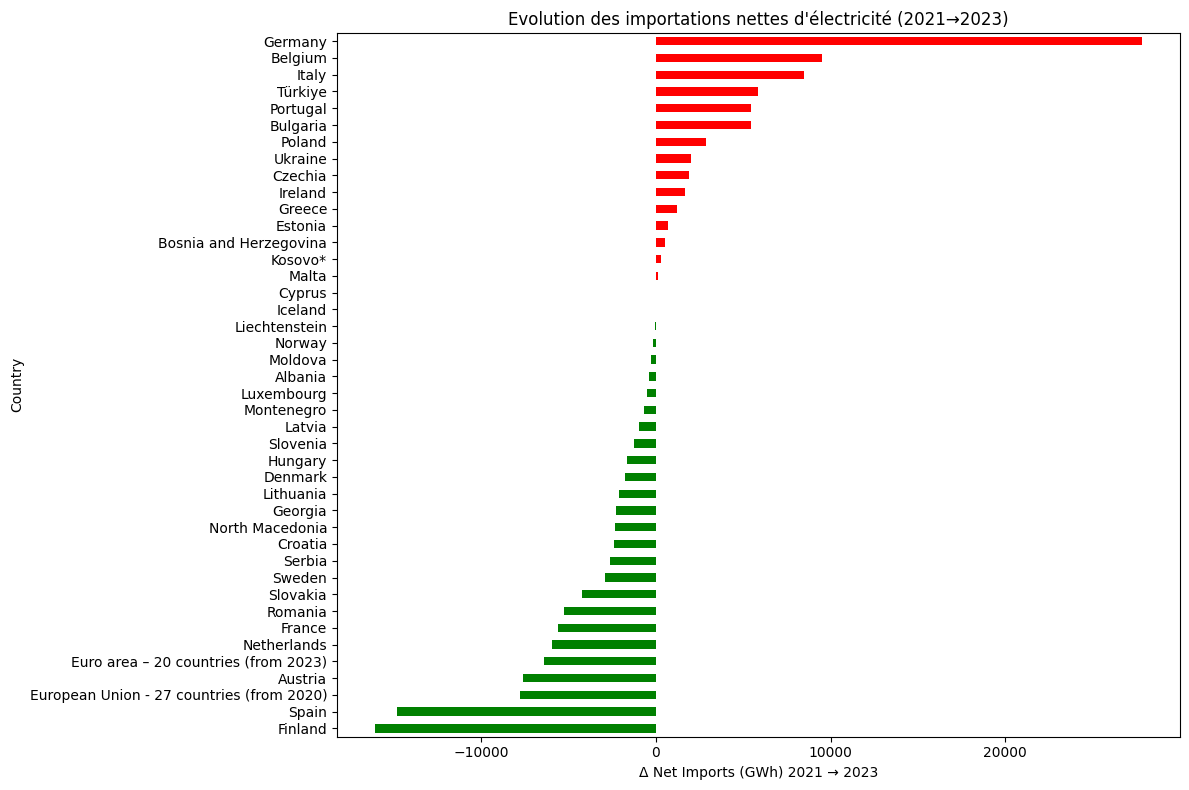

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load only needed columns to speed things up
usecols = ["freq", "nrg_bal", "geo", "TIME_PERIOD", "OBS_VALUE"]
df = pd.read_csv("imports-exports-fc.total.csv", usecols=usecols)

# 2. Clean and filter
df = df[df["freq"] == "Annual"]                        # only annual data
df = df[df["TIME_PERIOD"].isin([2021, 2022, 2023])]    # years of interest
df = df[df["nrg_bal"].isin(["Imports", "Exports"])]    # keep only imports/exports

# 3. Ensure numeric values
df["TIME_PERIOD"] = df["TIME_PERIOD"].astype(int)
df["OBS_VALUE"]   = pd.to_numeric(df["OBS_VALUE"], errors="coerce")
df = df.dropna(subset=["OBS_VALUE"])

# 4. Pivot so Imports and Exports are columns
pivot = df.pivot_table(
    index=["geo", "TIME_PERIOD"],
    columns="nrg_bal",
    values="OBS_VALUE",
    aggfunc="sum"
).fillna(0)

# 5. Compute Net Imports = Imports − Exports
pivot["Net Imports"] = pivot["Imports"] - pivot["Exports"]
pivot = pivot.reset_index()

# 6. Re-pivot to get one row per country, columns for each year
net_by_year = pivot.pivot(
    index="geo",
    columns="TIME_PERIOD",
    values="Net Imports"
).fillna(0)

# 7. Compute the 2021→2023 change
net_by_year["Change 2021–2023"] = net_by_year[2023] - net_by_year[2021]

# 8. Sort and plot
net_sorted = net_by_year.sort_values("Change 2021–2023", ascending=False)

plt.figure(figsize=(12, 8))
colors = ["green" if v < 0 else "red" for v in net_sorted["Change 2021–2023"]]
net_sorted["Change 2021–2023"].plot.barh(color=colors)
plt.xlabel("Δ Net Imports (GWh) 2021 → 2023")
plt.ylabel("Country")
plt.title("Evolution des importations nettes d'électricité (2021→2023)")
plt.gca().invert_yaxis()   # afficher le plus grand en haut
plt.tight_layout()
plt.show()



2 ème graphique, qui illustre l'évolution du mix énergétique

In [ ]:
# 1. Charger les données
df = pd.read_csv("energy_production.csv")

# 2. Total par source et pays
pivot = df.pivot_table(index=['country', 'year'], columns='source', values='production', aggfunc='sum').fillna(0)

# 3. Normaliser (obtenir un mix énergétique en %)
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100
pivot_pct = pivot_pct.reset_index()

# 4. Sélectionner les 5 pays les plus dépendants au gaz russe
# (Tu peux le faire à partir des données d'importations russes vues précédemment, dis-moi si tu veux l'automatiser)

top5 = ['Germany', 'Hungary', 'Italy', 'Slovakia', 'Austria']  # exemple

# 5. Tracer pour chaque année
import matplotlib.pyplot as plt

for year in [2021, 2022, 2023]:
    plt.figure(figsize=(10,6))
    df_plot = pivot_pct[(pivot_pct['year'] == year) & (pivot_pct['country'].isin(top5))]
    df_plot.set_index('country').drop('year', axis=1).T.plot(kind='bar', stacked=True)
    plt.title(f"Mix énergétique des 5 pays les plus dépendants (en %) - {year}")
    plt.ylabel('% de la production totale')
    plt.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


3ème graphique, qui illustre la consommation énergétique finale des pays européens en fonction du temps, et met en évidence les 5 pays les plus à risque

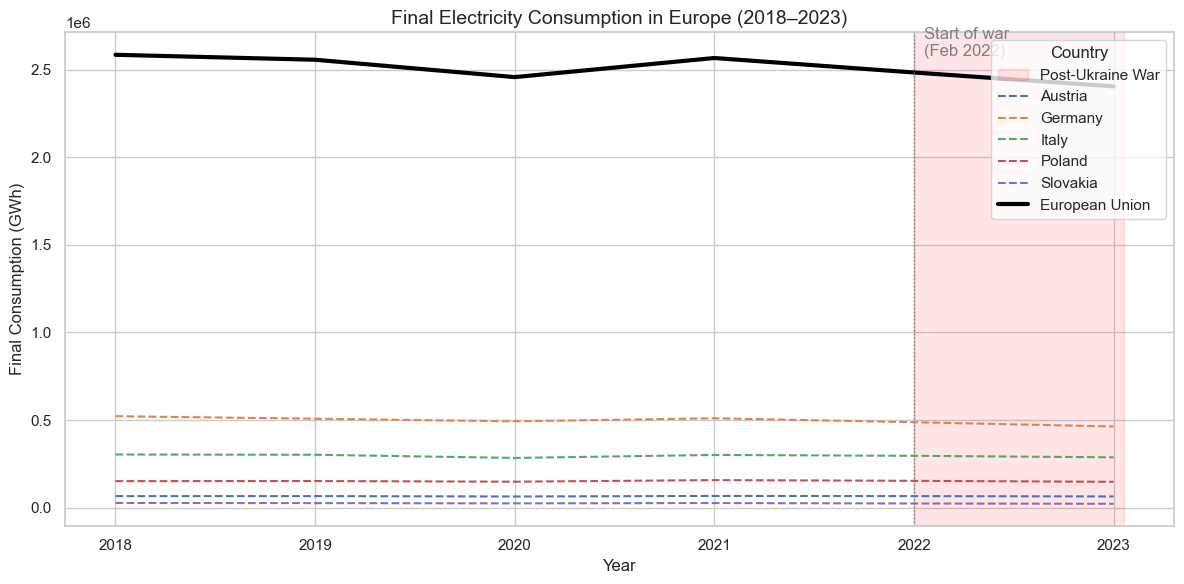

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("imports-exports-fc.total.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Filter for Final Consumption only
fc = df[df['nrg_bal'] == 'Final consumption'].copy()
# Rename for convenience
fc['Year'] = pd.to_numeric(fc['TIME_PERIOD'], errors='coerce')
fc['Value'] = pd.to_numeric(fc['OBS_VALUE'], errors='coerce')
fc['Country'] = fc['geo']
# Keep only the years you need
fc = fc[fc['Year'].between(2018, 2023)]

# Define focus countries and full EU list
focus_countries = ["Austria", "Slovakia", "Italy", "Germany", "Poland"]
eu_countries = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia',
    'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia',
    'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania',
    'Slovakia', 'Slovenia', 'Spain', 'Sweden'
]

# Aggregate EU-wide final consumption
eu_fc = fc[fc['Country'].isin(eu_countries)]
eu_summary = eu_fc.groupby('Year')['Value'].sum().reset_index()
eu_summary['Country'] = 'European Union'

# Extract the five focus countries
focus_df = fc[fc['Country'].isin(focus_countries)]

# Combine for plotting
combined = pd.concat([focus_df[['Country','Year','Value']], eu_summary], ignore_index=True)

# Plot with seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Shade post-war period
plt.axvspan(2022, 2023.05, color='red', alpha=0.1, label='Post-Ukraine War')

# Draw each series
for country in combined['Country'].unique():
    subset = combined[combined['Country'] == country]
    if country == "European Union":
        sns.lineplot(data=subset, x='Year', y='Value',
                     label=country, linewidth=3, color='black')
    else:
        sns.lineplot(data=subset, x='Year', y='Value',
                     label=country, linewidth=1.5, linestyle='--')

# Mark start of war
plt.axvline(2022, color='grey', linestyle=':', linewidth=1)
plt.text(2022 + 0.05, plt.ylim()[1]*0.95, 'Start of war\n(Feb 2022)', color='grey')

# Final touches
plt.title("Final Electricity Consumption in Europe (2018–2023)", fontsize=14)
plt.ylabel("Final Consumption (GWh)")
plt.xlabel("Year")
plt.legend(title="Country", loc='upper right')
plt.tight_layout()
plt.show()


Même graphique que le précdent, mais normalisé

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load & rename columns
df = pd.read_csv("imports-exports-fc.total.csv")
df.columns = df.columns.str.strip()

# 2. Keep only annual final‐consumption data
df = df[df["freq"] == "Annual"]
df = df[df["nrg_bal"] == "Final consumption"]

# 3. Map to convenient names and types
df["Year"]    = pd.to_numeric(df["TIME_PERIOD"], errors="coerce")
df["Value"]   = pd.to_numeric(df["OBS_VALUE"],   errors="coerce")
df["Country"] = df["geo"].str.strip()

# 4. Filter years 2018–2023
df = df[df["Year"].between(2018, 2023)]

# 5. Define focus & EU countries
focus_countries = ["Austria", "Slovakia", "Italy", "Germany", "Poland"]
eu_countries = [
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia',
    'Finland','France','Germany','Greece','Hungary','Ireland','Italy','Latvia',
    'Lithuania','Luxembourg','Malta','Netherlands','Poland','Portugal','Romania',
    'Slovakia','Slovenia','Spain','Sweden'
]

# 6. Aggregate EU total
eu_df = df[df["Country"].isin(eu_countries)]
eu_summary = eu_df.groupby("Year")["Value"].sum().reset_index()
eu_summary["Country"] = "European Union"

# 7. Extract focus countries
focus_df = df[df["Country"].isin(focus_countries)][["Country","Year","Value"]]

# 8. Combine & normalize to 2018=100%
combined = pd.concat([focus_df, eu_summary], ignore_index=True)
base = combined[combined["Year"] == 2018][["Country","Value"]].rename(columns={"Value":"Base"})
norm = combined.merge(base, on="Country")
norm["Pct_of_2018"] = norm["Value"] / norm["Base"] * 100

# 9. Plot
sns.set(style="whitegrid")
plt.figure(figsize=(12,6))

# shade post-war
plt.axvspan(2022, 2023.05, color="red", alpha=0.1)
plt.axvline(2022, color="grey", linestyle=":", linewidth=1)
plt.text(2022+0.05, 108, "Start of war\n(Feb 2022)", color="grey")

# lines
for country in norm["Country"].unique():
    sub = norm[norm["Country"] == country]
    if country == "European Union":
        sns.lineplot(data=sub, x="Year", y="Pct_of_2018",
                     label=country, linewidth=3, color="black")
    else:
        sns.lineplot(data=sub, x="Year", y="Pct_of_2018",
                     label=country, linewidth=1.8, linestyle="--")

# formatting
plt.title("Final Electricity Consumption (2018 = 100%)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Consumption (% of 2018)")
plt.ylim(80, 110)
plt.legend(title="Country", loc="lower left")
plt.tight_layout()
plt.show()


4ème graphique, qui affiche les emissions de GHG en fonction du temps, avec la moyenne de l'UE puis les 5 pays qui sont plus touchés

In [ ]:
# 1. Charger
df = pd.read_csv("ghg_emissions.csv")

# 2. Moyenne européenne
europe_avg = df.groupby('year')['ghg_emissions'].mean()

# 3. Tracer
plt.figure(figsize=(10,6))
plt.plot(europe_avg.index, europe_avg.values, label="Moyenne européenne", linewidth=3, color='green')

for country in top5:
    country_data = df[df['country'] == country]
    plt.plot(country_data['year'], country_data['ghg_emissions'], label=country)

plt.title("Émissions nettes de GES (MtCO₂e)")
plt.ylabel("MtCO₂e")
plt.legend()
plt.show()
